## Libraies:

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, metrics
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional # Keras's layers
from tqdm import tqdm
from collections import Counter
import librosa
import matplotlib.pyplot as plt

## Common settings and params:

In [45]:
# Change working directory:
os.chdir('C:/Users/Alex/Desktop/Vega-VAD project/')
train_file_1 = 'data/train_features1.csv'
train_file_2 = 'data/train_features2.csv'
test_file_1 = 'data/test_features1.csv'
test_file_2 = 'data/test_features2.csv'
real_signal_BILSTM = 'data/real_BILSTM.csv'
real_signal_CNN_BILSTM = 'data/real_CNN_BILSTM.csv'
filename_real_wav = 'data/real/room.wav'

# Common params:
fs = 16000
frame_length = 0.025
frame_step = 0.01

# Params for ViVoVAD model:
n_frames = 300 # Number frames in one batch for BILSTM
epochs_ViVoVAD = 25 # Number epochs for BILSTM
batch_size_ViVoVAD = 64 # Number batchs for BILSTM

# Params for a Hybrid CNN-BiLSTM:
n_features = 32

## Load data:

In [3]:
train_1 = pd.read_csv(train_file_1, header=None)
train_2 = pd.read_csv(train_file_2, header=None)
valid_1 = pd.read_csv(test_file_1, header=None)
valid_2 = pd.read_csv(test_file_2, header=None)
real_1 = pd.read_csv(real_signal_BILSTM, header=None)
real_2 = pd.read_csv(real_signal_CNN_BILSTM, header=None)

train_1 = np.array(train_1)
train_2 = np.array(train_2)
valid_1 = np.array(valid_1)
valid_2 = np.array(valid_2)
real_1 = np.array(real_1)
real_2 = np.array(real_2)

print('Train size', train_1.shape, train_2.shape)
print('Valid size', valid_1.shape, valid_2.shape)
print('Real size', real_1.shape, real_2.shape)

Train size (5382000, 34) (162000, 1025)
Valid size (1794000, 34) (54000, 1025)
Real size (899, 33) (28, 1024)


# ViVoVAD:a Voice Activity Detection Tool based on Recurrent Neural Networks

## Build and training model:

We will use BiLSTM layers stacked with linear layer on output. In order to reduce the delay of the dependencies, training and evaluation is perfomed with limited length sequences of 300 frames (3 seconds).

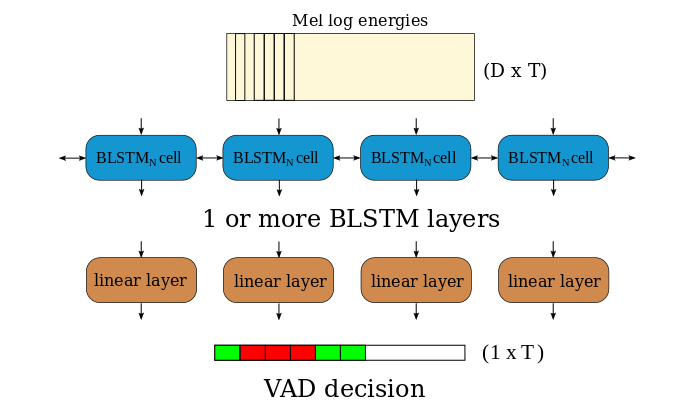

## Preparation data:

We need to split into test and train sets and to scale data to input the model.

In [169]:
# Split dataset on train and test:
X = train_1[:, 1:]
y = train_1[:, 0]
y = [1 if x == 0 else 0 for x in y]
y = np.array(y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, shuffle=True, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Scale data:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape datasets to 1 x 300 x num_features:
# So, each group need to consist of 300 frames:
X_train_reshaped = X_train[:int(X_train.shape[0] / n_frames) * n_frames]
X_train_reshaped = X_train_reshaped.reshape(int(X_train_reshaped.shape[0] / n_frames), n_frames, X_train_reshaped.shape[1])
X_test_reshaped = X_test[:int(X_test.shape[0] / n_frames) * n_frames]
X_test_reshaped = X_test_reshaped.reshape(int(X_test_reshaped.shape[0] / n_frames), n_frames, X_test_reshaped.shape[1])

(3605940, 33) (1776060, 33) (3605940,) (1776060,)


In [170]:
# Encoding label:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_reshaped = y_train[:int(y_train.shape[0] / n_frames) * n_frames]
y_train_reshaped = y_train_reshaped.reshape(int(y_train_reshaped.shape[0] / n_frames), n_frames, y_train_reshaped.shape[1])
y_test_reshaped = y_test[:int(y_test.shape[0] / n_frames) * n_frames]
y_test_reshaped = y_test_reshaped.reshape(int(y_test_reshaped.shape[0] / n_frames), n_frames, y_test_reshaped.shape[1])

## Build and fit model:

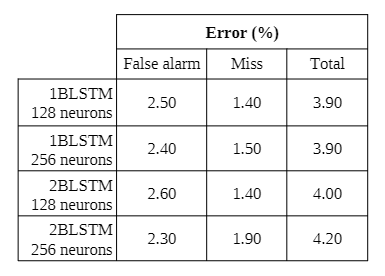
According pics we need to use the next struct for model:
1 layer with 128 neurons to reduse miss.

In [173]:
input_layer = Input(shape=(n_frames, X_train.shape[1]))
BiLSTM_1_layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
output_layer = TimeDistributed(Dense(2, activation='sigmoid'))(BiLSTM_1_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [174]:
model.fit(X_train_reshaped, y_train_reshaped, validation_data=(X_test_reshaped, y_test_reshaped), epochs=epochs_ViVoVAD, batch_size=batch_size_ViVoVAD)

Epoch 1/25
188/188 [==============================] - 163s 857ms/step - loss: 0.5044 - accuracy: 0.7246 - val_loss: 0.4579 - val_accuracy: 0.7627
Epoch 2/25
188/188 [==============================] - 166s 886ms/step - loss: 0.4476 - accuracy: 0.7697 - val_loss: 0.4380 - val_accuracy: 0.7773
Epoch 3/25
188/188 [==============================] - 175s 931ms/step - loss: 0.4313 - accuracy: 0.7823 - val_loss: 0.4252 - val_accuracy: 0.7869
Epoch 4/25
188/188 [==============================] - 179s 950ms/step - loss: 0.4208 - accuracy: 0.7900 - val_loss: 0.4177 - val_accuracy: 0.7923
Epoch 5/25
188/188 [==============================] - 177s 943ms/step - loss: 0.4140 - accuracy: 0.7948 - val_loss: 0.4118 - val_accuracy: 0.7968
Epoch 6/25
188/188 [==============================] - 178s 945ms/step - loss: 0.4085 - accuracy: 0.7988 - val_loss: 0.4098 - val_accuracy: 0.7985
Epoch 7/25
188/188 [==============================] - 178s 949ms/step - loss: 0.4025 - accuracy: 0.8032 - val_loss: 0.3999 -

## Do the validation:

In [8]:
X_valid = valid_1[:, 1:]
order_record = valid_1[:, 0]
last_number = order_record[-1]
list_number = np.arange(0, last_number + 1, 1)
list_predicted_labels = list()

# Scaling:
X_valid = scaler.transform(X_valid)

for i in list_number:
    # Choose frames:
    indexes = [j for j in range(len(order_record)) if order_record[j] == i]
    
    # Reshape datasets to 1 x 300 x num_features:
    X_valid_tmp = X_valid[indexes[0]:indexes[-1] + 1]
    if X_valid_tmp.shape[0] < n_frames:
        added_frames = np.zeros((n_frames - X_valid_tmp.shape[0], X_valid_tmp.shape[1]))
        X_valid_tmp = np.vstack((X_valid_tmp, added_frames))
    X_valid_reshaped = X_valid_tmp[:int(X_valid_tmp.shape[0] / n_frames) * n_frames]
    X_valid_reshaped = X_valid_reshaped.reshape(int(X_valid_reshaped.shape[0] / n_frames), n_frames, X_valid_reshaped.shape[1])
    prediction = model.predict(X_valid_reshaped)
    
    predicted_label = np.zeros(prediction.shape[0] * prediction.shape[1])
    shift = prediction.shape[1]
    for j in range(prediction.shape[0]):
        for jj in range(prediction.shape[1]):
            predicted_label[jj + j * shift] = np.argmax(prediction[j][jj])
            
    list_predicted_labels.append(Counter(predicted_label).most_common()[0][0])

In [9]:
list_predicted_labels

[2.0,
 2.0,
 0.0,
 0.0,
 1.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 0.0,
 0.0,
 2.0,
 0.0,
 2.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 2.0,
 0.0,
 2.0,
 0.0,
 1.0,
 1.0,
 0.0,
 2.0,
 0.0,
 2.0,
 2.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 2.0,
 2.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 0.0,
 2.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 2.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 1.0,
 2.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 2.0,
 0.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 0.0,
 2.0,
 2.0,
 0.0,
 0.0

## Check on real signal:

In [10]:
# Scaling:
real_1_scaled = scaler.transform(real_1)
new_shape = int(np.ceil(real_1_scaled.shape[0] / n_frames))

# Reshape datasets to new_shape x 300 x num_features:
real_1_reshaped = np.zeros((new_shape, n_frames, real_1_scaled.shape[1]))

begin = 0
end = n_frames
for i in range(new_shape):
    if i != new_shape - 1:
        real_1_reshaped[i, :, :] = real_1_scaled[begin:end, :]
    else:
        # Last sequence just fill in to last memory cell:
        real_1_reshaped[i, :real_1_scaled[begin:, :].shape[0], :] = real_1_scaled[begin:, :]
    begin = end
    end = end + n_frames

# Make prediction:
maked_prediction = model.predict(real_1_reshaped)
predicted_real_labels = np.zeros(maked_prediction.shape[0] * maked_prediction.shape[1])
shift = maked_prediction.shape[1]
for j in range(maked_prediction.shape[0]):
    for jj in range(maked_prediction.shape[1]):
        predicted_real_labels[jj + j * shift] = np.argmax(maked_prediction[j][jj])

In [11]:
sig, sample_rate = librosa.load(filename_real_wav, sr=fs)

time_series_labels_speech = np.zeros(sig.shape[0])
time_series_labels_music = np.zeros(sig.shape[0])
time_series_labels_noise = np.zeros(sig.shape[0])

begin = 0
end = int(frame_length * sample_rate)
shift = int(frame_step * sample_rate)
for i in range(predicted_real_labels.shape[0]):
    if predicted_real_labels[i] == 0:
        time_series_labels_speech[begin:end] = 1
    elif predicted_real_labels[i] == 1:
        time_series_labels_music[begin:end] = 1
    else:
        time_series_labels_noise[begin:end] = 1
    begin = begin + shift
    end = end + shift 

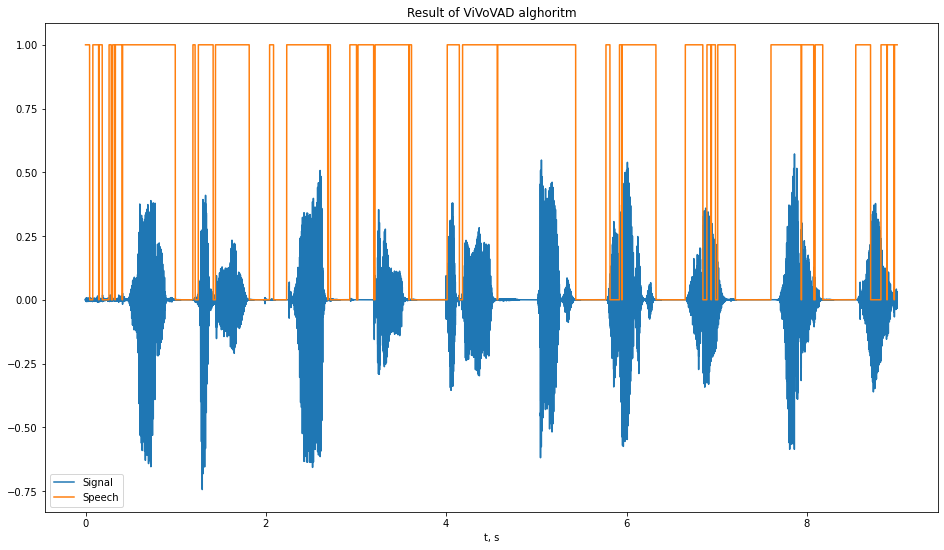

In [12]:
time_line = np.linspace(0, sig.shape[0] / sample_rate, sig.shape[0])

plt.figure(figsize=(16, 9))
plt.title('Result of ViVoVAD alghoritm')
plt.plot(time_line, sig)
plt.plot(time_line, time_series_labels_speech)
plt.xlabel('t, s')
plt.legend(['Signal', 'Speech'], loc='best')

## Smoothing out model answers:

In [13]:
from scipy.signal import medfilt
sm = medfilt(time_series_labels_speech, kernel_size=3)

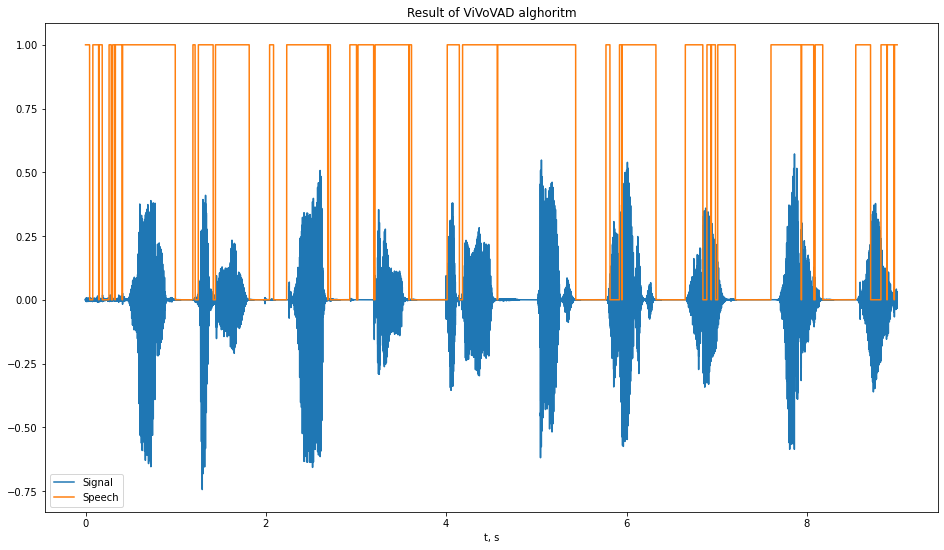

In [14]:
plt.figure(figsize=(16, 9))
plt.title('Result of ViVoVAD alghoritm')
plt.plot(time_line, sig)
plt.plot(time_line, sm)
plt.xlabel('t, s')
plt.legend(['Signal', 'Speech'], loc='best')

# A Hybrid CNN-BiLSTM Voice Activity Detector

## Build and train model:

We will use CNN layers stacked with BiLSTM layer to classify voice fragments in records. Inputs for model will images collected from several frames of features. 

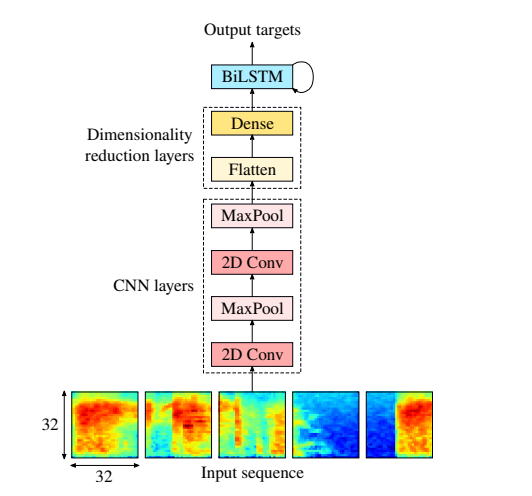

## Preparation data:

We need to split into test and train sets and to scale data to input the model.

In [46]:
# Split dataset on train and test:
X = train_2[:, 1:]
y = train_2[:, 0]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, shuffle=True, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Scale data:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape into image:
X_train = X_train.reshape(X_train.shape[0], n_features, n_features)
X_test = X_test.reshape(X_test.shape[0], n_features, n_features)

(108540, 1024) (53460, 1024) (108540,) (53460,)


In [49]:
# Encoding label:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [55]:
# Reshape data for convolution layer:
stride = int(15)

X_train_reshaped = X_train[:int(np.floor(X_train.shape[0] / stride) * stride)]
X_test_reshaped = X_test[:int(np.floor(X_test.shape[0] / stride) * stride)]

y_train_reshaped = y_train[:int(np.floor(X_train.shape[0] / stride) * stride)]
y_test_reshaped = y_test[:int(np.floor(X_test.shape[0] / stride) * stride)]

X_train_reshaped = X_train_reshaped.reshape((int(X_train_reshaped.shape[0] / stride), stride, n_features, n_features, 1))
X_test_reshaped = X_test_reshaped.reshape((int(X_test_reshaped.shape[0] / stride), stride, n_features, n_features, 1))

y_train_reshaped = y_train_reshaped.reshape((int(y_train_reshaped.shape[0] / stride), stride, y_train[-1].shape[0]))
y_test_reshaped = y_test_reshaped.reshape((int(y_test_reshaped.shape[0] / stride), stride, y_test[-1].shape[0]))

In [56]:
X_train_reshaped.shape

(7236, 15, 32, 32, 1)

## Build and fit model:

In [58]:
from tensorflow.keras import models, layers

In [59]:
model = models.Sequential()
model.add(layers.TimeDistributed(layers.Conv2D(64, (5, 5), activation='elu'), input_shape=(stride, n_features, n_features, 1)))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.TimeDistributed(layers.Dense(64, activation='elu')))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
model.add(layers.Dropout(0.5))
model.add(layers.TimeDistributed(layers.Dense(y_train[-1].shape[0], activation='softmax')))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [60]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [61]:
epochs = 25
batch_size = 32
callbacks = None

model.fit(X_train_reshaped, y_train_reshaped,
          validation_data=(X_test_reshaped, y_test_reshaped),
          epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/25
227/227 [==============================] - 79s 340ms/step - loss: 0.4367 - accuracy: 0.6745 - val_loss: 0.4205 - val_accuracy: 0.7169
Epoch 2/25
227/227 [==============================] - 76s 334ms/step - loss: 0.3152 - accuracy: 0.7991 - val_loss: 0.2690 - val_accuracy: 0.8330
Epoch 3/25
227/227 [==============================] - 75s 330ms/step - loss: 0.2693 - accuracy: 0.8327 - val_loss: 0.2403 - val_accuracy: 0.8525
Epoch 4/25
227/227 [==============================] - 77s 339ms/step - loss: 0.2490 - accuracy: 0.8464 - val_loss: 0.2347 - val_accuracy: 0.8556
Epoch 5/25
227/227 [==============================] - 76s 334ms/step - loss: 0.2339 - accuracy: 0.8579 - val_loss: 0.2210 - val_accuracy: 0.8652
Epoch 6/25
227/227 [==============================] - 76s 337ms/step - loss: 0.2235 - accuracy: 0.8632 - val_loss: 0.2247 - val_accuracy: 0.8638
Epoch 7/25
227/227 [==============================] - 76s 334ms/step - loss: 0.2169 - accuracy: 0.8685 - val_loss: 0.2116 - val_ac

## Do the validation:

In [111]:
X_valid = valid_2[:, 1:]
order_record = valid_2[:, 0]
last_number = order_record[-1]
list_number = np.arange(0, last_number + 1, 1)
list_predicted_labels = list()

# Scaling:
X_valid = scaler.transform(X_valid)

for i in list_number:
    # Choose frames:
    indexes = [j for j in range(len(order_record)) if order_record[j] == i]
    
    # Reshaping:
    X_valid_tmp = X_valid[indexes[0]:indexes[-1] + 1]
    X_valid_tmp = X_valid_tmp.reshape(X_valid_tmp.shape[0], n_features, n_features)
    
    if stride - X_valid_tmp.shape[0] > 0:
        for j in range(stride - X_valid_tmp.shape[0]):
            X_valid_tmp = np.vstack((X_valid_tmp, np.zeros((1, n_features, n_features))))
    
    X_valid_reshaped = X_valid_tmp[:int(np.floor(X_valid_tmp.shape[0] / stride) * stride)]
    X_valid_reshaped = X_valid_reshaped.reshape((int(X_valid_tmp.shape[0] / stride), stride, n_features, n_features, 1))
    prediction = model.predict(X_valid_reshaped)
    
    predicted_label = np.zeros(prediction.shape[0] * prediction.shape[1])
    shift = prediction.shape[1]
    for j in range(prediction.shape[0]):
        for jj in range(prediction.shape[1]):
            predicted_label[jj + j * shift] = np.argmax(prediction[j][jj])
            
    list_predicted_labels.append(Counter(predicted_label).most_common()[0][0])

'\n    if X_valid_tmp.shape[0] < n_frames:\n        added_frames = np.zeros((n_frames - X_valid_tmp.shape[0], X_valid_tmp.shape[1]))\n        X_valid_tmp = np.vstack((X_valid_tmp, added_frames))\n    X_valid_reshaped = X_valid_tmp[:int(X_valid_tmp.shape[0] / n_frames) * n_frames]\n    X_valid_reshaped = X_valid_reshaped.reshape(int(X_valid_reshaped.shape[0] / n_frames), n_frames, X_valid_reshaped.shape[1])\n    prediction = model.predict(X_valid_reshaped)\n    \n    predicted_label = np.zeros(prediction.shape[0] * prediction.shape[1])\n    shift = prediction.shape[1]\n    for j in range(prediction.shape[0]):\n        for jj in range(prediction.shape[1]):\n            predicted_label[jj + j * shift] = np.argmax(prediction[j][jj])\n            \n    list_predicted_labels.append(Counter(predicted_label).most_common()[0][0])\n'

In [112]:
list_predicted_labels

[2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 0.0,
 2.0,
 0.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 0.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 1.0,
 2.0,
 0.0,
 1.0,
 1.0,
 2.0,
 2.0,
 0.0,
 2.0,
 1.0,
 1.0,
 1.0,
 0.0,
 2.0,
 0.0,
 2.0,
 2.0,
 0.0,
 0.0,
 1.0,
 2.0,
 0.0,
 2.0,
 2.0,
 0.0,
 2.0,
 2.0,
 0.0,
 2.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 2.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 2.0,
 0.0,
 2.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 0.0,
 0.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 0.0,
 2.0,
 0.0,
 1.0,
 2.0,
 0.0,
 1.0,
 2.0,
 0.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 0.0,
 1.0,
 2.0,
 0.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 0.0,
 0.0

## Check on real signal:

In [148]:
# Scaling:
real_2_scaled = scaler.transform(real_2)
real_2_scaled_tmp = real_2_scaled.reshape((real_2_scaled.shape[0], n_features, n_features))
new_shape = int(np.ceil(real_2_scaled_tmp.shape[0] / stride))

# Reshaping:
if new_shape * stride - real_2_scaled_tmp.shape[0] > 0:
    for i in range(new_shape * stride - real_2_scaled_tmp.shape[0]):
        real_2_scaled_tmp = np.vstack((real_2_scaled_tmp, np.zeros((1, n_features, n_features))))
        
real_2_reshaped = real_2_scaled_tmp.reshape((new_shape, stride, n_features, n_features))
maked_prediction = model.predict(real_2_reshaped)
predicted_real_labels = np.zeros(maked_prediction.shape[0] * maked_prediction.shape[1])

shift = maked_prediction.shape[1]
for i in range(maked_prediction.shape[0]):
    for j in range(maked_prediction.shape[1]):
        predicted_real_labels[j + i * shift] = np.argmax(maked_prediction[i][j])
real_labels = np.array([x for x in predicted_real_labels for i in range(n_features)])

In [167]:
sig, sample_rate = librosa.load(filename_real_wav, sr=fs)

time_series_labels_speech = np.zeros(sig.shape[0])
time_series_labels_music = np.zeros(sig.shape[0])
time_series_labels_noise = np.zeros(sig.shape[0])

begin = 0
end = int(frame_length * sample_rate)
shift = int(frame_step * sample_rate)
for i in range(real_labels.shape[0]):
    if real_labels[i] == 0:
        time_series_labels_speech[begin:end] = 1
    elif real_labels[i] == 1:
        time_series_labels_music[begin:end] = 1
    else:
        time_series_labels_noise[begin:end] = 1
    begin = begin + shift
    end = end + shift 

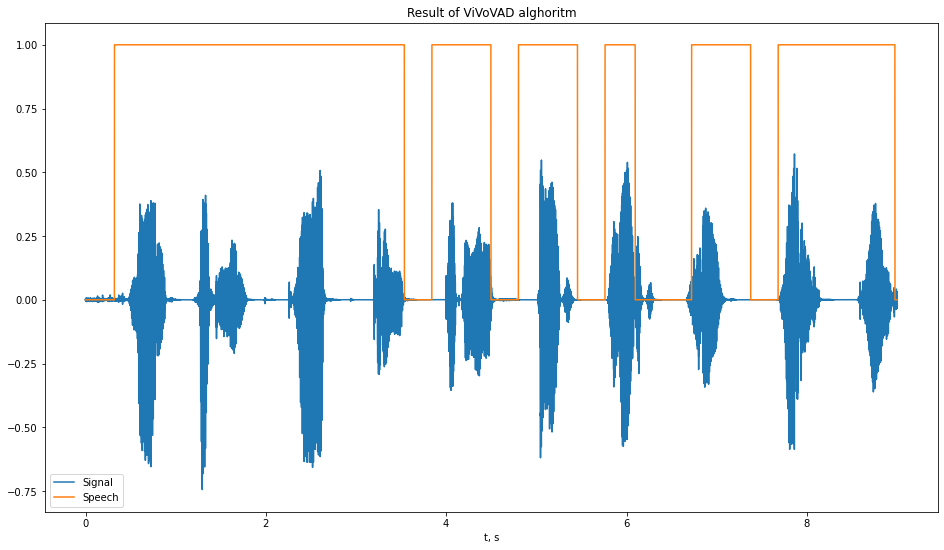

In [168]:
time_line = np.linspace(0, sig.shape[0] / sample_rate, sig.shape[0])

plt.figure(figsize=(16, 9))
plt.title('Result of ViVoVAD alghoritm')
plt.plot(time_line, sig)
plt.plot(time_line, time_series_labels_speech)
plt.xlabel('t, s')
plt.legend(['Signal', 'Speech'], loc='best')

In [151]:
real_1.shape

(899, 33)

In [152]:
real_2.shape

(28, 1024)